# Análise pelo modelo XGBoost

## Projeto de Mapeamento Marinho Apresentado Nas Jornadas de Engenharia Hidrográfica

## Diogo Ceddia Porto Silva

#### Importação de bibliotecas

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Carregando dado

In [2]:
dado_linhas = pd.read_csv("C:\DCPS\GitHub\Dados_MapeamentoIA_JEH\dado_linhas.txt")

#### Separando target/feature e treino/validação

In [3]:
features = ['z','bs','sl','as','dist_lc','dist_ds']
target = ['classe']

X = dado_linhas[features]
y = dado_linhas[target]

X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X,columns=features)

train_size=0.2
test_size=0.8
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0,
                                                        train_size=train_size, 
                                                        test_size=test_size, 
                                                        stratify=y.classe)

#### Treinamento do modelo preliminar

In [4]:
model = XGBClassifier()

start = time.time()
model.fit(X_train, y_train.values.ravel(), eval_metric='merror')
y_pred = model.predict(X_valid)
end=time.time()
y_pred = pd.DataFrame(y_pred,columns=['classe'])

print('Tempo de treinamento',end-start,'segundos')
print(f'{train_size*100}% para treinar')
print(f'{test_size*100}% para validar')

C:\Users\User W10\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Tempo de treinamento 2.7929272651672363 segundos
20.0% para treinar
80.0% para validar


In [5]:
# Métrica de acurácia considerando o dado desbalanceado
precisao = metrics.balanced_accuracy_score(y_valid, y_pred)
print(f'A precisão do modelo é de {(precisao*100).round(3)}%')

A precisão do modelo é de 98.876%


#### Treinamento do modelo com tuning

In [6]:
params = {'learning_rate': [0.62], 'max_depth': [7], 'n_estimators': [1310]}
grid_search = GridSearchCV(model, param_grid = params,cv=5, n_jobs=-1, scoring='balanced_accuracy')
grid_search.fit(X_train, y_train, eval_metric='merror')

print('A precisão tunada é de',np.round(100*grid_search.score(X, y),3),'%')

C:\Users\User W10\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\User W10\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


A precisão tunada é de 99.471 %


#### Matriz Confusão

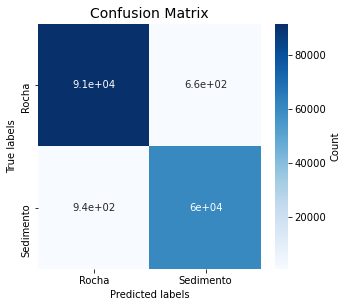

In [7]:
cm = metrics.confusion_matrix(y_valid, y_pred)

fig, ax = plt.subplots(figsize=(5,4.5))
# ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap = 'Blues', cbar_kws={'label': 'Count'});
# labels, title and ticks
ax.set_title('Confusion Matrix', size=14); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Rocha', 'Sedimento'])
ax.yaxis.set_ticklabels(['Rocha', 'Sedimento']);

#### Correlação de Spearman

Text(0.5, 1.0, 'Correlation Matrix')

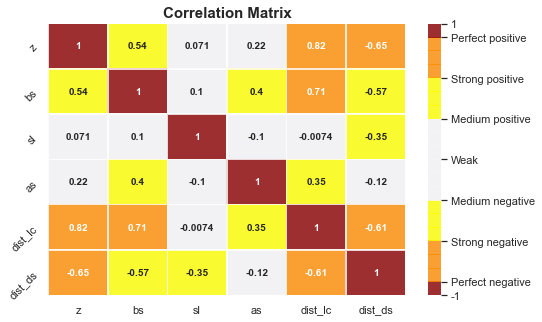

In [8]:
from matplotlib.colors import LinearSegmentedColormap

correlated_features = set()
correlation_matrix = X.corr(method='spearman')

sns.set(font_scale=1)

colors = ['darkred',
          'darkorange','darkorange','darkorange',
          'yellow','yellow','yellow',
          'whitesmoke','whitesmoke','whitesmoke','whitesmoke','whitesmoke','whitesmoke',
          'yellow','yellow','yellow',
          'darkorange','darkorange','darkorange',
          'darkred']
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax = 1 ,cmap=cmap, annot=True, 
                  linewidths = .5, alpha=0.8, annot_kws = {"fontsize":10,"fontweight":"bold"})
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9, 1])
c_bar.set_ticklabels(['-1',
                      'Perfect negative',
                      'Strong negative', 
                      'Medium negative',
                      'Weak',
                      'Medium positive',
                      'Strong positive',
                      'Perfect positive',
                      '1'])

plt.yticks(rotation=45)
# plt.xticks(rotation=270) 
plt.title('Correlation Matrix',fontsize=15,fontweight="bold")

#### Mapa de incertezas

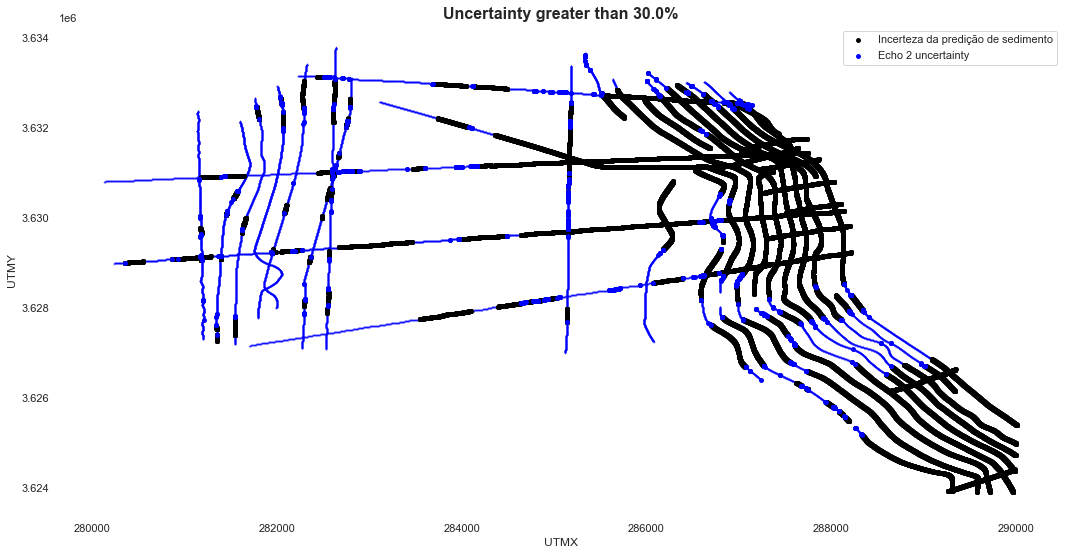

In [9]:
plt.rcParams['axes.facecolor'] = 'white'

size = 60

fig = plt.figure(figsize=(18,9))

plt.scatter(dado_linhas.utmx.iloc[np.where(dado_linhas.classe == 0)[0]], dado_linhas.utmy.iloc[np.where(dado_linhas.classe == 0)[0]],
            s=1, color='black', marker='*', alpha=0.1)
plt.scatter(dado_linhas.utmx.iloc[np.where(dado_linhas.classe == 1)[0]], dado_linhas.utmy.iloc[np.where(dado_linhas.classe == 1)[0]], 
            s=1, color='blue', marker='*', alpha=0.1)

incerteza = model.predict_proba(X)
perc_inc = 0.70

plt.scatter(dado_linhas.utmx.iloc[np.where(((incerteza[:,0] < perc_inc) * dado_linhas.classe == 0)==True)[0]],
            dado_linhas.utmy.iloc[np.where(((incerteza[:,0] < perc_inc) * dado_linhas.classe == 0)==True)[0]],
            s=size, color='black', marker='.', label='Incerteza da predição de sedimento')
plt.scatter(dado_linhas.utmx.iloc[np.where(((incerteza[:,1] < perc_inc) * dado_linhas.classe == 1)==True)[0]],
            dado_linhas.utmy.iloc[np.where(((incerteza[:,1] < perc_inc) * dado_linhas.classe == 1)==True)[0]],
            s=size, color='blue', marker='.', label='Echo 2 uncertainty')

plt.title(f'Uncertainty greater than {np.round((1-perc_inc)*100)}%',size=16,fontweight='bold')
plt.xlabel('UTMX')
plt.ylabel('UTMY')
plt.legend()
plt.grid(c='grey',alpha=0.5)

In [10]:
import shap

start=time.time()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
end=time.time()
print(end-start)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


9.307487487792969


In [11]:
np.abs(shap_values[0]).mean(axis=0)

1.0212485

In [12]:
shap_sum1.tolist()

NameError: name 'shap_sum1' is not defined

In [ ]:
shap_sum1 = np.abs(shap_values[0]).mean(axis=0)
importance_df1 = pd.DataFrame([X_train.columns.tolist(), shap_sum1.tolist()]).T
importance_df1.columns = ['column_name', 'imp']
shap_sum2 = np.abs(shap_values[1]).mean(axis=0)
importance_df2 = pd.DataFrame([X_train.columns.tolist(), shap_sum2.tolist()]).T
importance_df2.columns = ['column_name', 'imp']

In [ ]:

shap_sum1 = np.abs(shap_values[0]).mean(axis=0)
importance_df1 = pd.DataFrame([X_train.columns.tolist(), shap_sum1.tolist()]).T
importance_df1.columns = ['column_name', 'imp']
shap_sum2 = np.abs(shap_values[1]).mean(axis=0)
importance_df2 = pd.DataFrame([X_train.columns.tolist(), shap_sum2.tolist()]).T
importance_df2.columns = ['column_name', 'imp']
shap_sum3 = np.abs(shap_values[2]).mean(axis=0)
importance_df3 = pd.DataFrame([X_train.columns.tolist(), shap_sum3.tolist()]).T
importance_df3.columns = ['column_name', 'imp']

a = importance_df1.imp * (len(np.where(data.classe==0)[0])/len(data))
b = importance_df2.imp * (len(np.where(data.classe==1)[0])/len(data))
imp_shap = a+b
imp_shap.index = importance_df1.column_name
#imp_shap = imp_shap.reindex(['BS','distOUTFALL','distGLACIER','Z','ASPECT','SLOPE'])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

testKbest = SelectKBest(score_func=f_classif, k=len(features))
fitKbest = testKbest.fit(X_train, y_train.values.ravel())
dff = pd.DataFrame(fitKbest.scores_,index=features)
dff.columns=['k']
#dff = dff.reindex(['BS','distOUTFALL','distGLACIER','Z','ASPECT','SLOPE'])

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,3.5))
plt.title('Feature Importance methods',size=16,fontweight='bold')
plt.ylabel('Variable Importance (%)',fontweight='bold')

imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='weight').items()),
                               columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10, label='weight', linestyle='dashed')


imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='gain').items()),
                               columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='gain', linestyle='dashed')

imp = pd.DataFrame(list(proantar_model.get_booster().get_score(importance_type='cover').items()),
                               columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='cover', linestyle='dashed')

imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='total_gain').items()),
                               columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='total_gain', linestyle='dashed')

imp = pd.DataFrame(list(model.get_booster().get_score(importance_type='total_cover').items()),
                               columns=['features','importance'])
x = imp.features
y = (imp.importance/sum(imp.importance))*100
plt.plot(x,y,marker='.',markersize=10,label='total_cover', linestyle='dashed')

plt.plot(dff.index, (dff.k/sum(dff.k))*100, marker='s', markersize=7, label='SelectKBest')

plt.plot(imp_shap.index, (imp_shap/sum(imp_shap))*100, 
         marker='^', markersize=7, label='SHAP', color='black')

plt.legend()
plt.grid()
